In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

----------------------
## Question 1-A
----------------------

In [35]:
df = pd.read_csv('data.csv')
df

,id,weight,sweetness,label
0,1,180,7,Apple
1,2,200,6,Apple
2,3,150,4,Orange
3,4,170,5,Orange
4,5,160,6,Apple
5,6,140,3,Orange


In [3]:
from math import sqrt

def knn_predict(df, weight, sweetness, k=3, metric='euclidean'):
    df = df.copy()
    weight /= df['weight'].max()
    sweetness /= df['sweetness'].max()
    df['weight'] /= df['weight'].max()
    df['sweetness'] /= df['sweetness'].max()
    df['distance'] = df.apply(lambda x: sqrt((x.weight - weight)**2 + (x.sweetness - sweetness)**2), axis=1)
    
    df.sort_values(by='distance', inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(df.head(10))
    return df.loc[:k-1, 'label'].value_counts(sort=True, ascending=False).index[0]

knn_predict(df, 165, 5.5, k=3)

   id  weight  sweetness   label  distance
0   5    0.80   0.857143   Apple  0.075677
1   4    0.85   0.714286  Orange  0.075677
2   2    1.00   0.857143   Apple  0.189016
3   3    0.75   0.571429  Orange  0.227032
4   1    0.90   1.000000   Apple  0.227032
5   6    0.70   0.428571  Orange  0.378386


'Apple'

In [ ]:
df

Decision Boundary for K = 3:


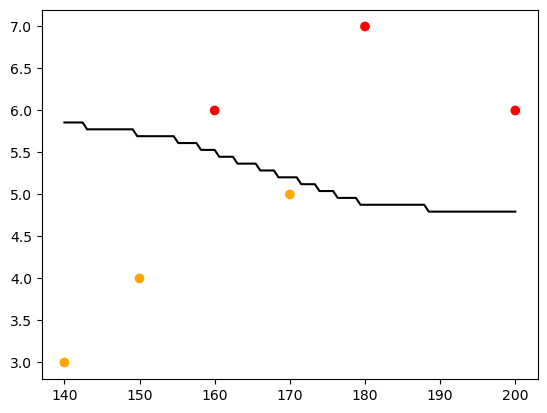

In [6]:
k = 3

color_map = {'Apple': 'red',
             'Orange': 'orange'}

weight_min, weight_max = int(df.weight.min()), int(df.weight.max())
sweetness_min, sweetness_max = int(df.sweetness.min()), int(df.sweetness.max())

boundary = []
# (weight_max - weight_min) // 100 + 1   (sweetness_max - sweetness_min) // 100 + 1

prev_label = None

for i in np.linspace(weight_min, weight_max, 100):
    prev_label = None
    for j in np.linspace(sweetness_min, sweetness_max, 50):
        cur_label = knn_predict(df, i, j, k=k)
        if prev_label is not None and prev_label != cur_label:
            boundary.append([i, j])
        prev_label = cur_label
            
w = [i[0] for i in boundary]
s = [i[1] for i in boundary]
            
fig = plt.figure()
plt.scatter(df.weight, df.sweetness, c=df.label.map(color_map))
# plt.scatter(165, 5.5)

plt.plot(w, s, 'black')

print(f'Decision Boundary for K = {k}:')

plt.show()

----------------------
## Question 1-B
----------------------

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


k = 3

scaler = MinMaxScaler()

model = KNeighborsClassifier(n_neighbors=k)

X = df[['weight', 'sweetness']].values.copy()

scaler.fit(X)

print(X)
X = scaler.transform(X)
print(X)

"""
weight_min, weight_max = df.weight.min(), df.weight.max()
sweetness_min, sweetness_max = df.sweetness.min(), df.sweetness.max()

X[:, 0] -= X[:, 0].min()
X[:, 1] -= X[:, 1].min()
X[:, 0] /= X[:, 0].max()
X[:, 1] /= X[:, 1].max()
"""

model.fit(X, df.label)

model.predict(scaler.transform([[150, 4]]))

[[180   7]
 [200   6]
 [150   4]
 [170   5]
 [160   6]
 [140   3]]
[[0.66666667 1.        ]
 [1.         0.75      ]
 [0.16666667 0.25      ]
 [0.5        0.5       ]
 [0.33333333 0.75      ]
 [0.         0.        ]]


array(['Orange'], dtype=object)

Decision Boundary for K = 3:


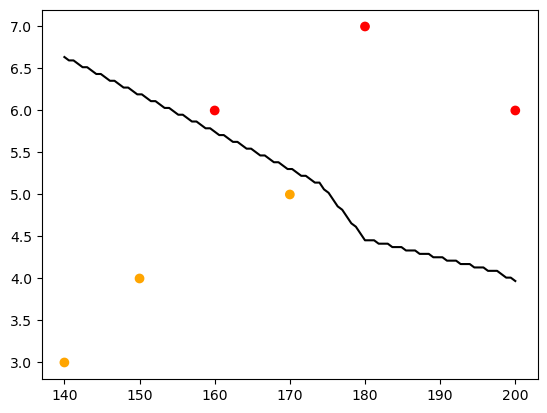

In [47]:
color_map = {'Apple': 'red',
             'Orange': 'orange'}

boundary = []

prev_label = None

for i in np.linspace(weight_min, weight_max, 100):
    prev_label = None
    for j in np.linspace(sweetness_min, sweetness_max, 100):
        cur_label = model.predict(scaler.transform([[i, j]]))[0]
        if prev_label is not None and prev_label != cur_label:
            boundary.append([i, j])
        prev_label = cur_label
            
w = [i[0] for i in boundary]
s = [i[1] for i in boundary]
            
fig = plt.figure()
plt.scatter(df.weight, df.sweetness, c=df.label.map(color_map))
# plt.scatter(165, 5.5)

plt.plot(w, s, 'black')
# print(boundary)

print(f'Decision Boundary for K = {k}:')

plt.show()

----------------------
## Question 2-A
----------------------

In [51]:
df = pd.read_csv('medical_data.csv')
df.head(20)

,id,age,bp,cholesterol,diagnosis
0,1,30,High,High,Sick
1,2,45,Low,Normal,Healthy
2,3,50,High,High,Sick
3,4,35,Low,Normal,Healthy
4,5,60,High,High,Sick
5,6,55,Low,Normal,Healthy
6,7,40,High,High,Sick
7,8,25,Low,Normal,Healthy
8,9,65,High,High,Sick
9,10,45,Low,Normal,Healthy


In [52]:
def calc_entropy(df, target_col):
    total = len(df)
    vals = df[target_col].value_counts()
    entropy = 0
    for val in vals:
        entropy += (val / total) * np.log(val / total)
    entropy *= -1
    return entropy

def calc_info_gain(df, predictor_col, target_col):
    total = len(df)
    initial_entropy = calc_entropy(df, target_col)
    cats = df[predictor_col].value_counts()
    entropy_after_split = 0
    for cat in cats.index:
        entropy_after_split += (cats[cat] / total) * calc_entropy(df[df[predictor_col] == cat], target_col)
        
    return initial_entropy - entropy_after_split
    
calc_info_gain(df, 'bp', 'diagnosis')

0.6931471805599453

In [53]:
for col in ['age', 'bp', 'cholesterol']:
    gain = calc_info_gain(df, col, 'diagnosis')
    print(f"Information Gain for column {col}: {gain}")

Information Gain for column age: 0.6931471805599453
Information Gain for column bp: 0.6931471805599453
Information Gain for column cholesterol: 0.6931471805599453


In [66]:
# Function to recursively build the decision tree using ID3 algorithm
def id3(data, original_data, features, target_attribute, parent_node_class=None):
    # Base case 1: If all target values are the same, return the class
    if len(np.unique(data[target_attribute])) <= 1:
        return np.unique(data[target_attribute])[0]
    
    # Base case 2: If dataset is empty, return the mode target feature value from the original dataset
    elif len(data) == 0:
        return np.unique(original_data[target_attribute])[np.argmax(np.unique(original_data[target_attribute], return_counts=True)[1])]
    
    # Base case 3: If the feature space is empty, return the parent node class
    elif len(features) == 0:
        return parent_node_class
    
    # Recursive case: Build the tree
    else:
        print(np.argmax(np.unique(data[target_attribute], return_counts=True)[1]))
        # Store the parent node class (the mode target feature value)
        parent_node_class = np.unique(data[target_attribute])[np.argmax(np.unique(data[target_attribute], return_counts=True)[1])]
        
        # Select the feature that best splits the dataset
        item_values = [calc_info_gain(data, feature, target_attribute) for feature in features]  # List of information gains
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        # Create the tree str ucture
        tree = {best_feature: {}}
        
        # Remove the best feature from the feature list
        features = [i for i in features if i != best_feature]
        
        # Grow the tree branch by branch for each feature in the best split
        for value in np.unique(data[best_feature]):
            sub_data = data[data[best_feature] == value]
            subtree = id3(sub_data, original_data, features, target_attribute, parent_node_class)
            tree[best_feature][value] = subtree
        
        return tree
    
    
def id3_predict(tree, data):
    sub_tree = tree
    while isinstance(sub_tree, dict):
        feature = list(sub_tree.keys())[0]
        sub_tree = sub_tree[feature][data[feature]]
    return sub_tree

In [67]:
df.columns[2:-1]

Index(['bp', 'cholesterol'], dtype='object')

In [68]:
tree = id3(df, df, df.columns[2: -1], 'diagnosis')
tree

{'bp': {'High': 'Sick', 'Low': 'Healthy'}}

In [81]:
id3_predict(tree, {'age': 50, 'bp': 'Low', 'chlesterol': 'Normal'})

'Healthy'